<a href="https://colab.research.google.com/github/TonioHathos/AI_Valeo/blob/main/Code_Yudi/Mod%C3%A8le2_Yudi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Livraria
---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, precision_score, \
                        recall_score, precision_recall_curve, roc_curve, \
                        roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram, plot_conf_mat, \
                      false_positive_rate, evaluate_anomaly_detector

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard
! pip install livelossplot
from livelossplot import PlotLossesKerasTF



# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile
from functools import partial, partialmethod


--2023-06-22 23:35:33--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py.6’

andrea_models.py.6  100%[===================>]   3.12K  --.-KB/s    in 0s      

2023-06-22 23:35:34 (31.7 MB/s) - ‘andrea_models.py.6’ saved [3190/3190]

--2023-06-22 23:35:34--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.


## Referencia

https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098

https://github.com/cran2367/autoencoder_classifier/blob/master/autoencoder_classifier.ipynb


#Download Dataset

In [2]:
! rm -f *.csv
! wget https://raw.githubusercontent.com/TonioHathos/AI_Valeo/main/Code_Yudi/df_yudi.csv
df_training_mod = pd.read_csv('df_yudi.csv')



--2023-06-22 23:35:44--  https://raw.githubusercontent.com/TonioHathos/AI_Valeo/main/Code_Yudi/df_yudi.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3334811 (3.2M) [text/plain]
Saving to: ‘df_yudi.csv’

df_yudi.csv         100%[===================>]   3.18M  --.-KB/s    in 0.07s   

2023-06-22 23:35:44 (47.1 MB/s) - ‘df_yudi.csv’ saved [3334811/3334811]



#Função seila

In [3]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s.
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.

    Inputs:
    df       A pandas dataframe with a binary labeled column.
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.

    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['Class'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'Class'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

#PreProcessing

In [4]:
df_training_mod.head()

,Rodage_U,V1_torque,Rodage_I,V2_torque,SnapRingMidPointForce,Premier angle,SnapRingPeakForce,Deuxième angle,Vissage_M8_torque,Capuchon_insertion,StartLinePeakForce,Vissage_M8_angle_log,SnapRingFinalStroke_exp,Binar OP130_Resultat_Global_v
0,11.97,1,113.64,1,109.62,180.4,190.51,173.1,12.16,0.0,26.37,2.933857,460468.625050,0
1,11.97,0,109.77,0,105.48,138.7,147.70,163.5,12.19,1.0,21.03,2.917771,498819.706587,0
2,11.97,1,109.79,1,100.03,180.9,150.87,181.2,12.24,0.0,25.81,2.862201,384615.725794,0
3,11.97,1,113.25,1,104.94,173.5,159.56,151.8,12.35,1.0,24.62,2.747271,369534.727474,0
4,11.97,1,112.88,1,99.19,174.5,172.29,177.5,12.19,0.0,29.22,3.514526,474491.982426,0


In [5]:
labels = df_training_mod['Binar OP130_Resultat_Global_v'].tolist()
df_training_mod['Class'] = labels  #Cpying values of diagnosis to newly clreated labels column
df_training_mod.head()  #Displaying first five rows of the dataset
df = df_training_mod

In [6]:
df.drop(columns = ['Binar OP130_Resultat_Global_v'])

,Rodage_U,V1_torque,Rodage_I,V2_torque,SnapRingMidPointForce,Premier angle,SnapRingPeakForce,Deuxième angle,Vissage_M8_torque,Capuchon_insertion,StartLinePeakForce,Vissage_M8_angle_log,SnapRingFinalStroke_exp,Class
0,11.97,1,113.64,1,109.62,180.4,190.51,173.1,12.16,0.0,26.37,2.933857,460468.625050,0
1,11.97,0,109.77,0,105.48,138.7,147.70,163.5,12.19,1.0,21.03,2.917771,498819.706587,0
2,11.97,1,109.79,1,100.03,180.9,150.87,181.2,12.24,0.0,25.81,2.862201,384615.725794,0
3,11.97,1,113.25,1,104.94,173.5,159.56,151.8,12.35,1.0,24.62,2.747271,369534.727474,0
4,11.97,1,112.88,1,99.19,174.5,172.29,177.5,12.19,0.0,29.22,3.514526,474491.982426,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34510,11.98,1,110.65,1,98.76,158.2,168.40,180.6,12.23,0.0,24.03,2.694627,392385.478850,0
34511,11.97,0,108.14,0,98.37,139.4,146.24,154.5,12.27,1.0,21.52,2.740840,460468.625050,0
34512,11.97,1,112.77,1,92.92,165.5,157.34,149.8,12.17,0.0,22.65,3.194583,484077.356303,0
34513,11.97,1,111.19,1,101.21,152.4,165.07,140.0,12.34,0.0,20.77,2.610070,469770.708316,0


#Teste de livrarias

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pylab import rcParams
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed
rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

# Train-test split

In [8]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=15)
df_train, df_valid = train_test_split(df_train, test_size=0.3, random_state=15)

df_train_0 = df_train.loc[df['Class'] == 0]
df_train_1 = df_train.loc[df['Class'] == 1]
df_train_0_x = df_train_0.drop(['Class'], axis=1)
df_train_1_x = df_train_1.drop(['Class'], axis=1)

df_valid_0 = df_valid.loc[df['Class'] == 0]
df_valid_1 = df_valid.loc[df['Class'] == 1]
df_valid_0_x = df_valid_0.drop(['Class'], axis=1)
df_valid_1_x = df_valid_1.drop(['Class'], axis=1)

df_test_0 = df_test.loc[df['Class'] == 0]
df_test_1 = df_test.loc[df['Class'] == 1]
df_test_0_x = df_test_0.drop(['Class'], axis=1)
df_test_1_x = df_test_1.drop(['Class'], axis=1)


In [9]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['Class'], axis = 1))
df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['Class'], axis = 1))

In [10]:
nb_epoch = 200
batch_size = 32
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables,
encoding_dim = 16
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-2

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense (Dense)               (None, 16)                240       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 14)                238       
                                                                 
Total params: 830
Trainable params: 830
Non-trainable params:

In [11]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Epoch 1/200
1047/1047 [==============================] - 9s 8ms/step - loss: 0.5287 - accuracy: 0.3486 - val_loss: 0.3243 - val_accuracy: 0.4852
Epoch 2/200
1047/1047 [==============================] - 5s 5ms/step - loss: 0.2677 - accuracy: 0.5416 - val_loss: 0.2230 - val_accuracy: 0.5945
Epoch 3/200
1047/1047 [==============================] - 8s 8ms/step - loss: 0.1832 - accuracy: 0.6283 - val_loss: 0.1467 - val_accuracy: 0.6739
Epoch 4/200
1047/1047 [==============================] - 7s 7ms/step - loss: 0.1318 - accuracy: 0.6896 - val_loss: 0.1199 - val_accuracy: 0.7098
Epoch 5/200
1047/1047 [==============================] - 8s 8ms/step - loss: 0.1148 - accuracy: 0.7130 - val_loss: 0.1101 - val_accuracy: 0.7076
Epoch 6/200
1047/1047 [==============================] - 5s 5ms/step - loss: 0.1078 - accuracy: 0.7174 - val_loss: 0.1057 - val_accuracy: 0.7133
Epoch 7/200
1047/1047 [==============================] - 3s 3ms/step - loss: 0.1035 - accuracy: 0.7181 - val_loss: 0.1039 - val_ac

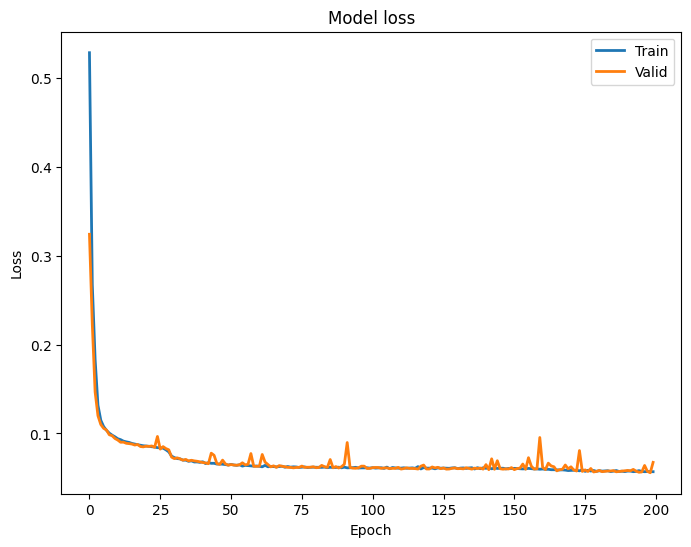

In [12]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

227/227 [==============================] - 1s 2ms/step


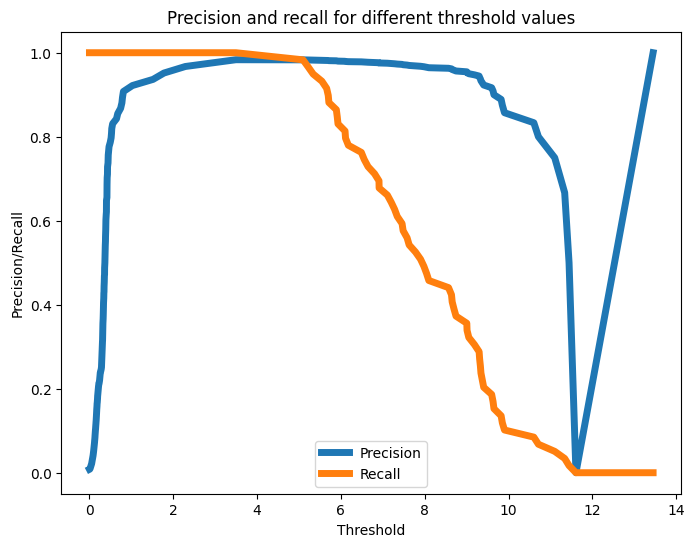

In [13]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['Class']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

324/324 [==============================] - 1s 2ms/step


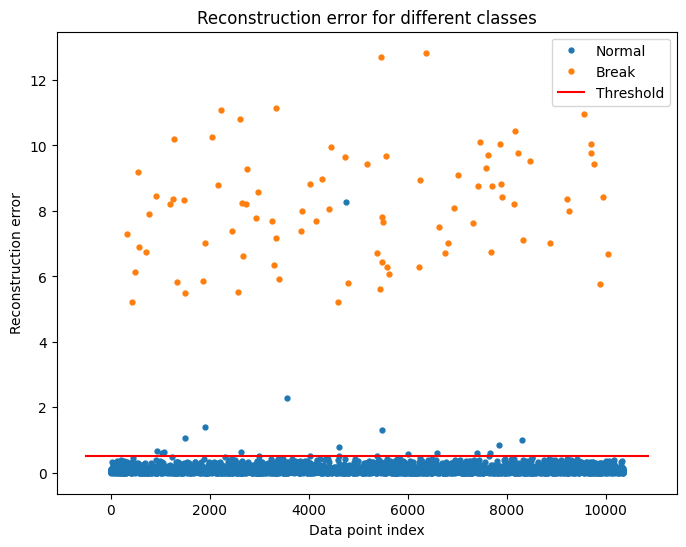

In [26]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['Class']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.5
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

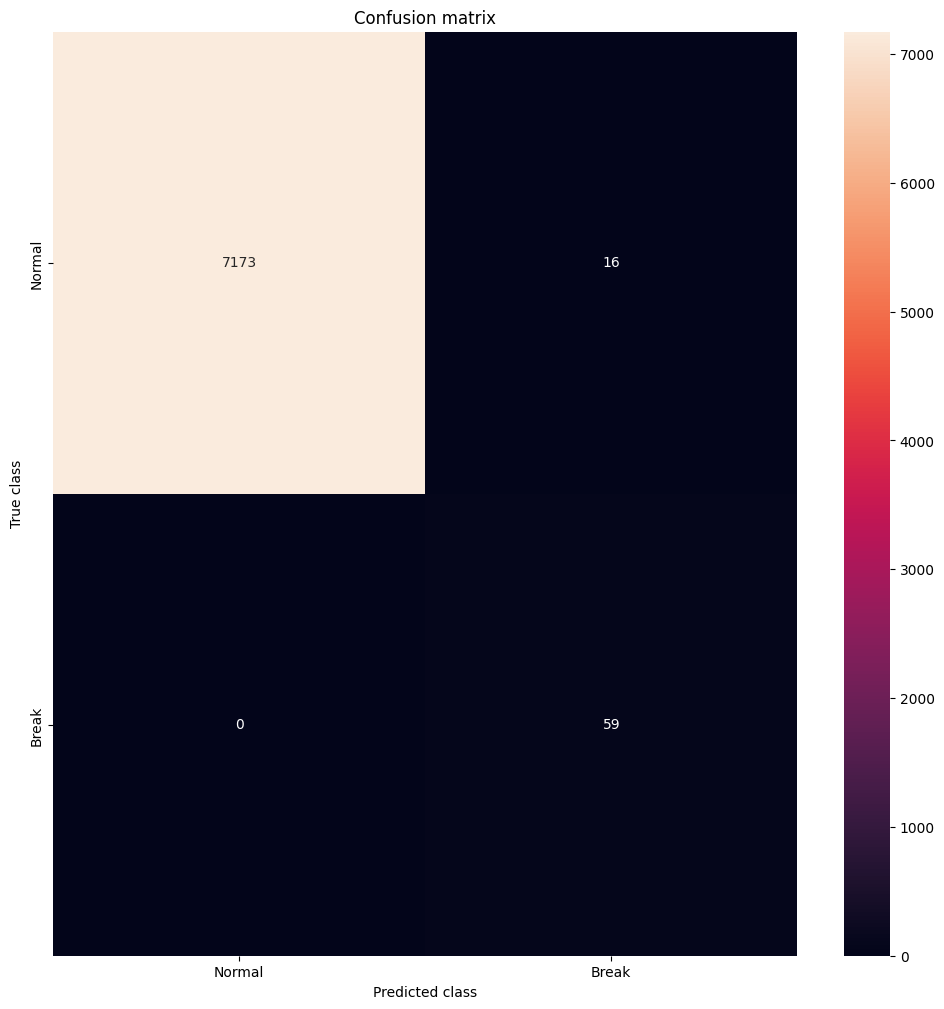

In [27]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

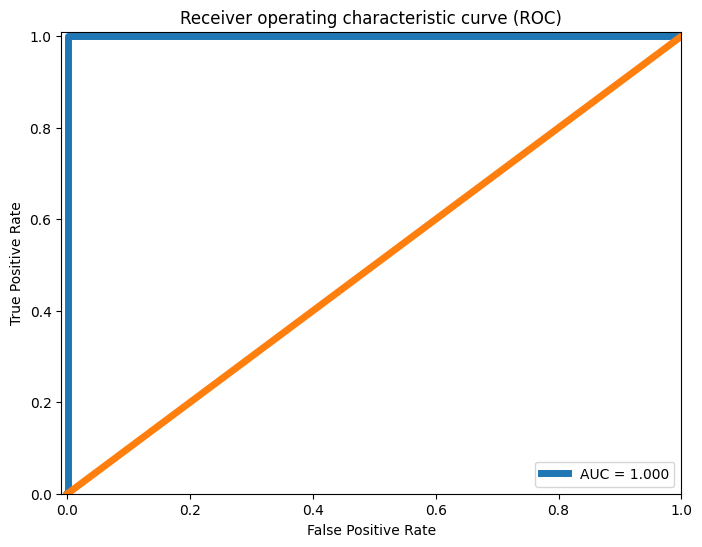

In [28]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate,
 linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()